In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils.visualization import density_plots

data = pd.read_pickle('results/overfitting_check_different_train_ranges.pkl')

reals_list = data['reals_list']
predictions_train_full_range_list = data['predictions_train_full_range']
predictions_train_mid_range_list = data['predictions_train_mid_range']
combined_titles = data['combined_titles']
molregnos_list = data['molregnos_list']

reals_list_dupped = reals_list + reals_list
molregnos_list_dupped = molregnos_list + molregnos_list

combined_titles_trained_on_full_range = [f'{title} (trained on full range)' for title in combined_titles]
combined_titles_trained_on_mid_range = [f'{title} (trained on mid range)' for title in combined_titles]
combined_titles_new = combined_titles_trained_on_full_range + combined_titles_trained_on_mid_range
predictions_list = predictions_train_full_range_list + predictions_train_mid_range_list
dims = (len(reals_list_dupped) // 2, 2)
assert len(reals_list_dupped) == len(predictions_list) == len(combined_titles_new) == len(molregnos_list_dupped), "List lengths are not consistent!"

density_plots(reals_list=reals_list_dupped, predictions_list=predictions_list, title=combined_titles_new, molregnos_list=molregnos_list_dupped, dims=dims)



In [ ]:

reals_list = data['reals_list']
predictions_train_full_range_list = data['predictions_train_full_range']
predictions_train_mid_range_list = data['predictions_train_mid_range']
combined_titles = data['combined_titles']
molregnos_list = data['molregnos_list']

reals_list_dupped = [reals_list] * 2
molregnos_list_dupped = [molregnos_list] * 2
combined_titles_trained_on_full_range = [f'{title} (trained on full range)' for title in combined_titles]
combined_titles_trained_on_mid_range = [f'{title} (trained on mid range)' for title in combined_titles]
combined_titles_new = combined_titles_trained_on_full_range + combined_titles_trained_on_mid_range
predictions_list = predictions_train_full_range_list + predictions_train_mid_range_list
dims = (len(reals_list), 2)


In [ ]:
density_plots(reals_list=reals_list_dupped, predictions_list=predictions_list, title=combined_titles_new, molregnos_list=molregnos_list_dupped, dims=dims)


In [ ]:
from utils.visualization import compile_metrics_dataframe
data_path = 'results/overfitting_check_different_train_ranges.pkl'
df_metrics_full_train_range = compile_metrics_dataframe(data_path,train_set='full_range')
df_metrics_mid_train_range = compile_metrics_dataframe(data_path,train_set='mid_range')

In [ ]:
df_metrics_full_train_range

In [ ]:
#for both, rank the models/descriptors according to kendall tau
df_metrics_full_train_range_kendalltau = df_metrics_full_train_range[df_metrics_full_train_range['Metric'] == 'KendallTau']
df_metrics_mid_train_range_kendalltau = df_metrics_mid_train_range[df_metrics_mid_train_range['Metric'] == 'KendallTau']
df_metrics_full_train_range_kendalltau = df_metrics_full_train_range_kendalltau.sort_values(by='Mean', ascending=False)
df_metrics_mid_train_range_kendalltau = df_metrics_mid_train_range_kendalltau.sort_values(by='Mean', ascending=False)
df_metrics_full_train_range_kendalltau

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_kendall_tau_heatmaps_with_difference(df1, df2, title1=' Heatmap (Full Range)', 
                                              title2=' Heatmap (Mid Range)', 
                                              diff_title='Difference (Full - Mid Range)',metric = 'KendallTau',model_order = ['MLP', 'XGB', 'RF', 'RF_SHORT', 'RIDGE'],descriptor_order = ['mfp3', 'RDKit_PhysChem', 'mfp0']):
    """
    Plot two heatmaps for Kendall Tau values with confidence intervals side-by-side, 
    and a third heatmap showing the differences between the two.

    Parameters:
    df1 (pd.DataFrame): DataFrame for the first heatmap with columns ['Model', 'Descriptor', 'Metric', 'Mean', 'CI_Low', 'CI_High']
    df2 (pd.DataFrame): DataFrame for the second heatmap with columns ['Model', 'Descriptor', 'Metric', 'Mean', 'CI_Low', 'CI_High']
    title1 (str): Title of the first heatmap
    title2 (str): Title of the second heatmap
    diff_title (str): Title of the difference heatmap
    """
    # Define model and descriptor orders for sorting
    title1 = metric + title1
    title2 = metric + title2
    df1 = df1[df1['Metric'] == metric]
    df2 = df2[df2['Metric'] == metric]

    # Filter for Kendall Tau metric and prepare DataFrames
    for df in [df1, df2]:
        df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
        df['Descriptor'] = pd.Categorical(df['Descriptor'], categories=descriptor_order, ordered=True)
    
    df1 = df1[df1['Metric'] == metric].sort_values(['Descriptor', 'Model'])
    df2 = df2[df2['Metric'] == metric].sort_values(['Descriptor', 'Model'])

    heatmap_data1 = df1.pivot(index='Descriptor', columns='Model', values='Mean')
    heatmap_data2 = df2.pivot(index='Descriptor', columns='Model', values='Mean')

    # Calculate the difference between the two heatmaps
    heatmap_diff = heatmap_data1 - heatmap_data2

    # Get the maximum absolute difference for symmetric color scaling
    max_diff = np.max(np.abs(heatmap_diff.values))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(36, 10))

    # Plot first heatmap
    sns.heatmap(heatmap_data1, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True, ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Descriptor')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)

    # Add text annotations for mean and CI to the first heatmap
    for i in range(heatmap_data1.shape[0]):
        for j in range(heatmap_data1.shape[1]):
            mean_val = heatmap_data1.iloc[i, j]
            if not pd.isnull(mean_val):
                ci_low = df1[
                    (df1['Descriptor'] == heatmap_data1.index[i]) &
                    (df1['Model'] == heatmap_data1.columns[j])
                ]['CI_Low'].values[0]
                ci_high = df1[
                    (df1['Descriptor'] == heatmap_data1.index[i]) &
                    (df1['Model'] == heatmap_data1.columns[j])
                ]['CI_High'].values[0]
                annotation_text = f"{mean_val:.2f}\n({ci_low:.2f}-{ci_high:.2f})"
                axes[0].text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='black', fontsize=8)

    # Plot second heatmap
    sns.heatmap(heatmap_data2, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True, ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Descriptor')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)

    # Add text annotations for mean and CI to the second heatmap
    for i in range(heatmap_data2.shape[0]):
        for j in range(heatmap_data2.shape[1]):
            mean_val = heatmap_data2.iloc[i, j]
            if not pd.isnull(mean_val):
                ci_low = df2[
                    (df2['Descriptor'] == heatmap_data2.index[i]) &
                    (df2['Model'] == heatmap_data2.columns[j])
                ]['CI_Low'].values[0]
                ci_high = df2[
                    (df2['Descriptor'] == heatmap_data2.index[i]) &
                    (df2['Model'] == heatmap_data2.columns[j])
                ]['CI_High'].values[0]
                annotation_text = f"{mean_val:.2f}\n({ci_low:.2f}-{ci_high:.2f})"
                axes[1].text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='black', fontsize=8)

    # Plot difference heatmap with centered color scale at 0
    sns.heatmap(heatmap_diff, annot=True, cmap='coolwarm', vmin=-max_diff, vmax=max_diff, center=0,
                fmt=".2f", linewidths=0.5, cbar=True, ax=axes[2])
    axes[2].set_title(diff_title)
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Descriptor')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_kendalltau, df_metrics_mid_train_range_kendalltau)


In [ ]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range, df_metrics_mid_train_range, metric='KendallTau')


In [ ]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range, df_metrics_mid_train_range, metric='Error_below_1')


In [ ]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range, df_metrics_mid_train_range, metric='MedianAE')


In [ ]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range, df_metrics_mid_train_range, metric='RMSE')


In [ ]:
df_metrics_full_train_range['Metric'].unique()

In [33]:
from utils.visualization import compile_metrics_dataframe
data_path = 'results/overfitting_check_different_train_ranges_Counts.pkl'
df_metrics_full_train_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='full_range')
df_metrics_full_mid_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='mid_range')

In [ ]:
df_metrics_full_mid_range_counts_and_physchem

50

/tmp/ipykernel_3406556/1143028607.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
/tmp/ipykernel_3406556/1143028607.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Descriptor'] = pd.Categorical(df['Descriptor'], categories=descriptor_order, ordered=True)


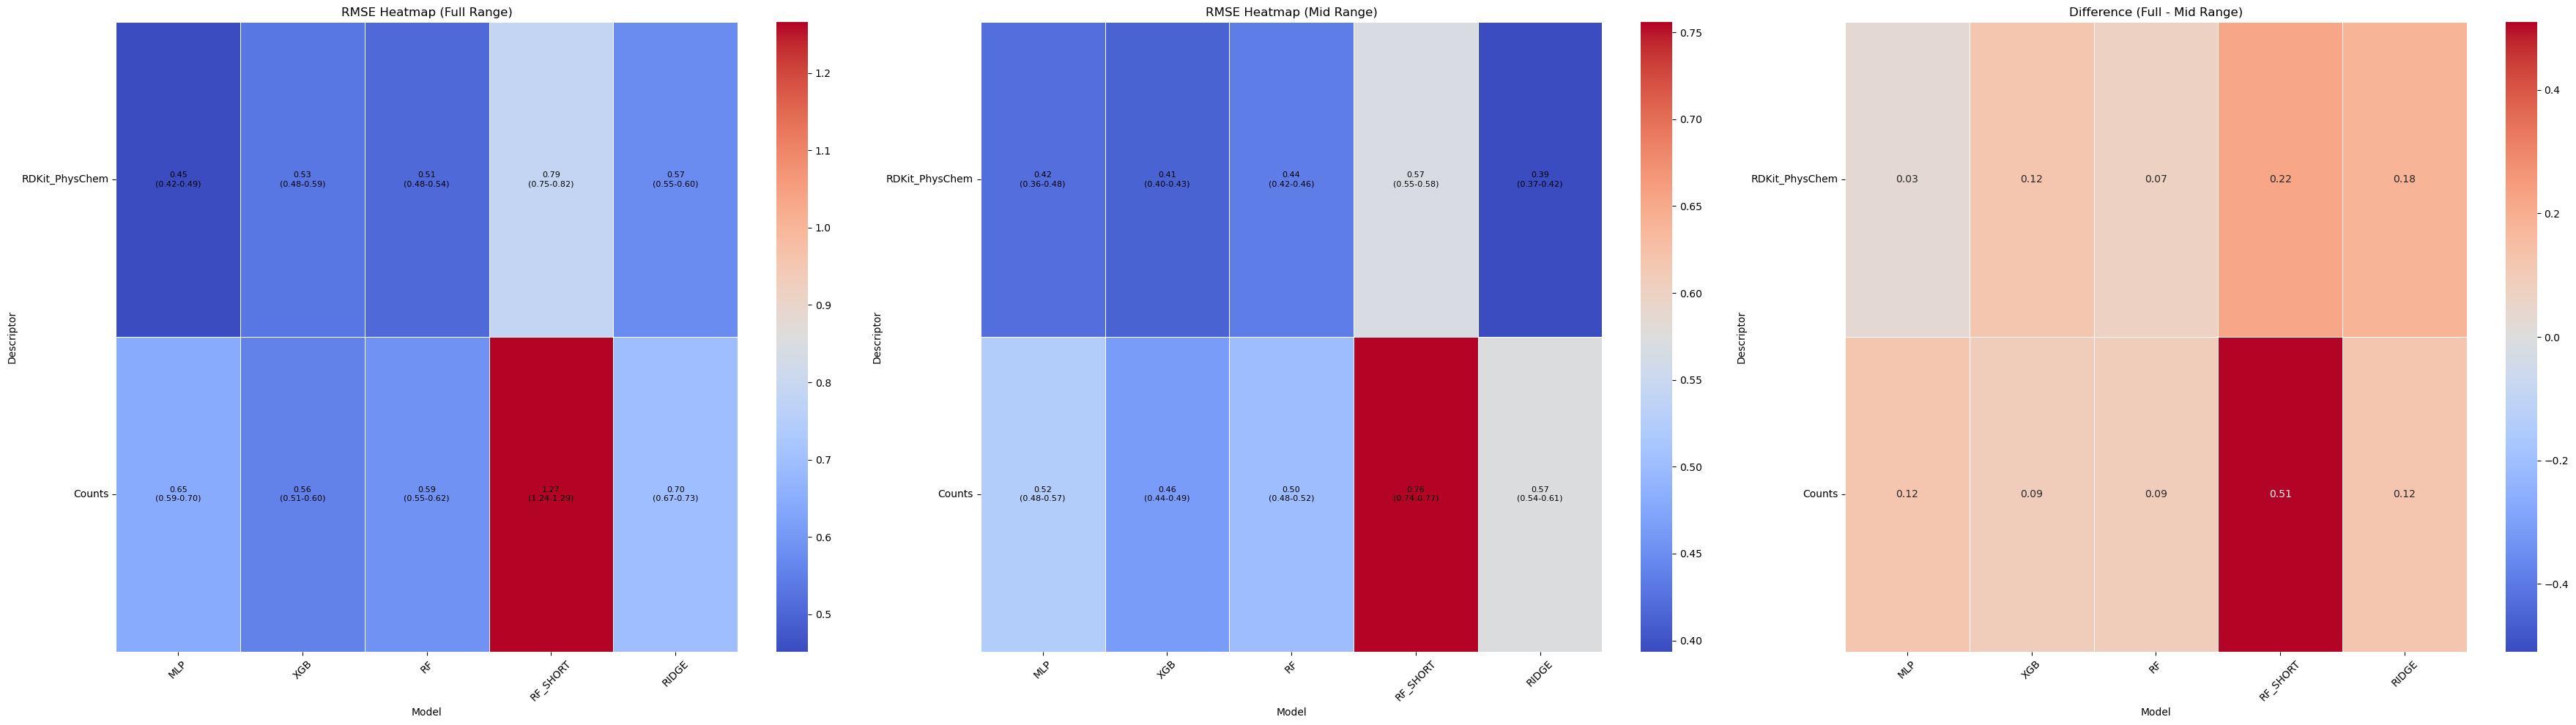

In [29]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='RMSE',descriptor_order=['RDKit_PhysChem', 'Counts'])

In [ ]:
plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='KendallTau',descriptor_order=['RDKit_PhysChem', 'Counts'])

In [ ]:
df_metrics_full_train_range_counts_and_physchem[df_metrics_full_train_range_counts_and_physchem['Metric'] == 'KendallTau']

In [ ]:
df_metrics_full_mid_range_counts_and_physchem[df_metrics_full_mid_range_counts_and_physchem['Metric'] == 'KendallTau']